In [1]:
import numpy as np
import tifffile
import matplotlib.pyplot as plt
%matplotlib inline

# from p4_copy2 import render_pose_rays
from plenoxel_og_copy2 import render_rays

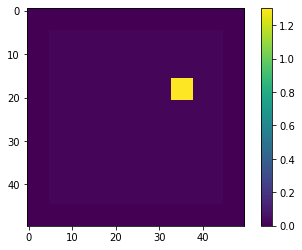

In [59]:
# Generate a very simple CT phantom consisting of two concentric cubes of different densities

reso = 50

volume = np.zeros((reso, reso, reso))

# Add a large medium-density cube
start = [reso//10, reso//10, reso//10]
extent = [4*reso//5] * 3
# volume[start[0]:start[0]+extent[0], start[1]:start[1]+extent[1], start[2]:start[2]+extent[2]] = 0.2
# super easy version
volume[start[0]:start[0]+extent[0], start[1]:start[1]+extent[1], start[2]:start[2]+extent[2]] = 0.02

# Add a small high-density cube
start = [reso//3, 2*reso//3, reso//2]
extent = [reso//10] * 3
# # Dense version; more challenging
# volume[start[0]:start[0]+extent[0], start[1]:start[1]+extent[1], start[2]:start[2]+extent[2]] = 1.3
# Less dense version; less challenging
# volume[start[0]:start[0]+extent[0], start[1]:start[1]+extent[1], start[2]:start[2]+extent[2]] = 0.3
# super easy version
# volume[start[0]:start[0]+extent[0], start[1]:start[1]+extent[1], start[2]:start[2]+extent[2]] = 0.05
# # very easy version
# volume[start[0]:start[0]+extent[0], start[1]:start[1]+extent[1], start[2]:start[2]+extent[2]] = 0.5
# semi easy version
volume[start[0]:start[0]+extent[0], start[1]:start[1]+extent[1], start[2]:start[2]+extent[2]] = 1.3

# plt.figure()
# plt.imshow(volume[reso//2, :, :])
# plt.colorbar()
# plt.show()
# plt.figure()
# plt.imshow(volume[:, reso//2, :])
# plt.colorbar()
# plt.show()
plt.figure()
plt.imshow(volume[:, :, reso//2])
plt.colorbar()
plt.show()


original density is 0.02


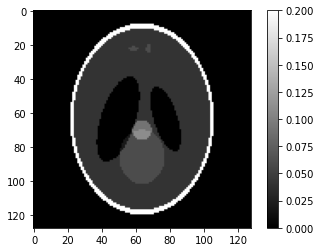

In [62]:
# Generate a more realistic phantom based on 3D Shepp-Logan, with varying the density of one of the ellipsoids

from phantominator import ct_shepp_logan

reso = 128
volume, E = ct_shepp_logan((reso, reso, reso), ret_E=True)

# Scale down all the densities so it's an easier problem
E[:,0] = E[:,0] / 5

ellipse_id = 5  # 4 is the medium size positive ellipsoid
print(f'original density is {E[ellipse_id, 0]}')
newdensity = 0.05
E[ellipse_id, 0] = newdensity
# Also make this ellipse a bit bigger so it's easier to see the effects
E[ellipse_id, 1] = E[ellipse_id, 1] * 2
E[ellipse_id, 2] = E[ellipse_id, 2] * 2

volume = ct_shepp_logan((reso, reso, reso), E=E)

slice = int(3/8. * reso)

plt.figure()
plt.imshow(volume[:,:,slice], cmap='gray')
plt.colorbar()

# plt.figure()
# plt.imshow(volume2[:,:,slice], cmap='gray')
# plt.colorbar()



In [63]:
# Render with the spike projection matrices, using render_pose_rays, and save as a tiff for training
# render_pose_rays(data_dict, c2w, H, W, focal, FLAGS.resolution, radius, FLAGS.harmonic_degree, FLAGS.jitter, FLAGS.uniform, key, sh_dim, FLAGS.physical_batch_size, FLAGS.interpolation, FLAGS.nv)
import jax
import jax.numpy as jnp
import math
import os
from tqdm import tqdm
import tifffile

# H = reso * 14
# W = reso * 14
H = int(reso * 1.1)
W = reso
# dW = 0.024
# dH = 0.024
dW = 0.12
dH = 0.12
data_dict = [volume]
resolution = reso
radius = 5
xoff =  0.0
yoff =  -1.3 # side to side (lower goes to left)
zoff =  -5.2 # up down (the higher the number the higher the cube goes)

def load_spike_c2w():
    all_w2c = []
    projection_matrices = np.genfromtxt(os.path.join('/home/fabriz/data/spike/', 'proj_mat_720frames.csv'), delimiter=',')  # [719, 12] /home/fabriz/data/spike/proj_mat_720frames.csv

    #Traslation matrix along x,y,z
    Tz = np.zeros((4,4))
    Tz[0,0]=1.0
    Tz[1,1]=1.0
    Tz[2,2]=1.0
    Tz[3,3]=1.0
    Tz[0,3]=-xoff #test
    Tz[1,3]=-yoff #test
    Tz[2,3]=-zoff #test

    for i in range(len(projection_matrices)): 
        # projection matrices P_(3,4)
        w2c = np.reshape(projection_matrices[i], (3,4))
        w2c = np.matmul(w2c,Tz) #applico una traslazione per centrate il volume
        all_w2c.append(w2c)

    return np.asarray(all_w2c)

def get_rays_np(H, W, dH, dW, w2c):
    # get M matrix
    M = w2c[:,0:3]
    # get  p4
    p4 = w2c[:,-1]

    # compute uo,vo,sdd
    uo = (M[0,:]*M[2,:]).sum()
    vo = (M[1,:]*M[2,:]).sum()
    aU = math.sqrt((M[0,:]*M[0,:]).sum() - uo*uo)
    aV = math.sqrt((M[1,:]*M[1,:]).sum() - vo*vo)
    sdd = 0.5*(aU+aV)

    #source position in the World Reference system
    M_inv = np.linalg.inv(M)
    srcPos = -np.matmul(M_inv,p4)
    
    shiftVo = (vo - 0.5 * H * dH)
    u, v = jnp.meshgrid(jnp.linspace(0, W-1, W) + 0.5, jnp.linspace(0, H-1, H) + 0.5)
    u = u * dW # u
    v = v * dH # v
    dirs   = jnp.stack([u, v, jnp.ones_like(u)], -1) 
    rays_d = jnp.sum(dirs[..., jnp.newaxis, :] * M_inv, -1) # check if the syntax is ok
    rays_o = jnp.broadcast_to(srcPos,rays_d.shape)          # check if the syntax is ok
    return rays_o, rays_d

all_c2w = load_spike_c2w()
all_rgbs = []
# for c2w in all_c2w[::50]:
for c2w in tqdm(all_c2w):
    rays_o, rays_d = get_rays_np(H, W, dH, dW, c2w)
    rays_o = np.reshape(rays_o, [-1,3])
    rays_d = np.reshape(rays_d, [-1,3])
    rgb, _, acc, _, _ = jax.lax.stop_gradient(render_rays(data_dict, (rays_o, rays_d), resolution, None, radius, harmonic_degree=-1, jitter=0, uniform=0.5, interpolation='trilinear', nv=False))
    rgb = np.reshape(rgb, (H, W))
    all_rgbs.append(rgb)
    # acc = np.reshape(acc, (H, W, 1))
    # plt.figure()
    # plt.imshow(acc)
    # plt.colorbar()
    # plt.show()
all_rgbs = np.array(all_rgbs)
print(all_rgbs.shape)
                                              

# tifffile.imsave(f'/home/datasets/ct_synthetic/semi_easy_synthetic_projections_raw_radius{radius}_reso{reso}_H{H}.tif', all_rgbs)
# tifffile.imsave(f'/home/datasets/ct_synthetic/semi_easy_synthetic_volume_reso{reso}.tif', volume)

tifffile.imsave(f'/home/datasets/ct_shepp/fifthdensity_{newdensity}_projections_raw_radius{radius}_reso{reso}_H{H}_W{W}_dhw{dH}.tif', all_rgbs)
tifffile.imsave(f'/home/datasets/ct_shepp/fifthdensity_{newdensity}_volume_reso{reso}.tif', volume)


100%|██████████| 720/720 [00:08<00:00, 87.05it/s] 


(720, 140, 128)


/tmp/ipykernel_37207/959672995.py:95: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(f'/home/datasets/ct_shepp/fifthdensity_{newdensity}_projections_raw_radius{radius}_reso{reso}_H{H}_W{W}_dhw{dH}.tif', all_rgbs)
/tmp/ipykernel_37207/959672995.py:96: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(f'/home/datasets/ct_shepp/fifthdensity_{newdensity}_volume_reso{reso}.tif', volume)


### Visualize slices of result

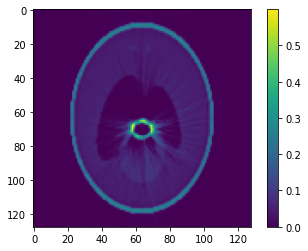

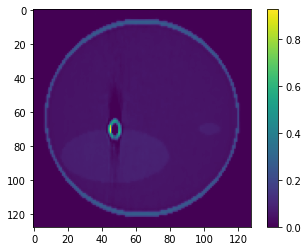

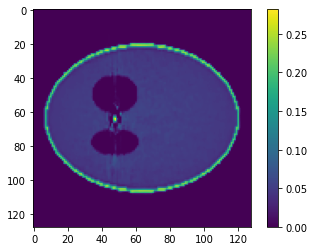

In [55]:


# nonlinear_path = 'jax_logs/synthetic/epoch_0/sigma_grid.npy'
# linear_path = 'jax_logs/synthetic_linearized/epoch_0/sigma_grid.npy'
# nonlinear_path = 'jax_logs/synthetic_nonnegative/epoch_0/sigma_grid.npy'
# linear_path = 'jax_logs/synthetic_linearized_nonnegative/epoch_0/sigma_grid.npy'

how_easy = 'semi_'

# nonlinear_path = f'jax_logs/{how_easy}easy_synthetic/epoch_0/sigma_grid.npy'
# linear_path = f'jax_logs/{how_easy}easy_synthetic_linearized/epoch_0/sigma_grid.npy'
# nonlinear_path = f'jax_logs/{how_easy}easy_synthetic_nonnegative/epoch_0/sigma_grid.npy'
# linear_path = f'jax_logs/{how_easy}easy_synthetic_linearized_nonnegative/epoch_0/sigma_grid.npy'

density = 1

nonlinear_path = f'jax_logs/shepp_fifthdensity/linear_{density}_nonnegative/epoch_0/sigma_grid.npy'
# linear_path = f'jax_logs/{how_easy}easy_synthetic_linearized_nonnegative/epoch_0/sigma_grid.npy'


nonlinear_grid = np.load(nonlinear_path)
# linear_grid = np.load(linear_path)

slice = int(3/8. * reso)

# fig, ax = plt.subplots(nrows=1, ncols=2)
# ax[0].imshow(nonlinear_grid[:,:,reso//2])
# ax[1].imshow(linear_grid[:,:,reso//2])
# ax[0].colorbar()
# plt.show()
plt.figure()
plt.imshow(nonlinear_grid[:,:,slice])
plt.colorbar()
plt.show()
# plt.figure()
# plt.imshow(linear_grid[:,:,reso//2])
# plt.colorbar()
# plt.show()

plt.figure()
plt.imshow(nonlinear_grid[:,reso//2,:])
plt.colorbar()
plt.show()
# plt.figure()
# plt.imshow(linear_grid[:,reso//2,:])
# plt.colorbar()
# plt.show()

plt.figure()
plt.imshow(nonlinear_grid[reso//2,:,:])
plt.colorbar()
plt.show()
# plt.figure()
# plt.imshow(linear_grid[reso//2,:,:])
# plt.colorbar()
# plt.show()

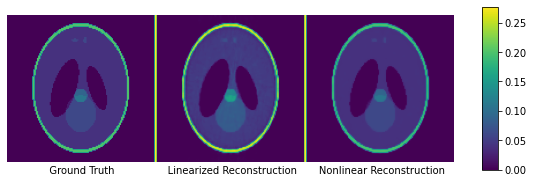

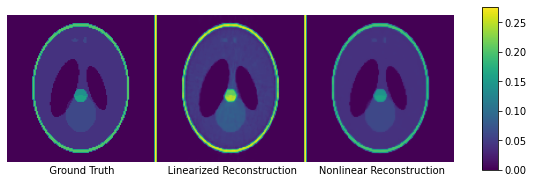

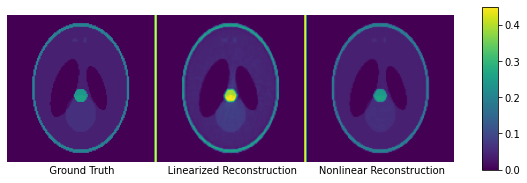

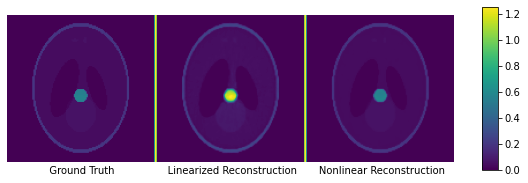

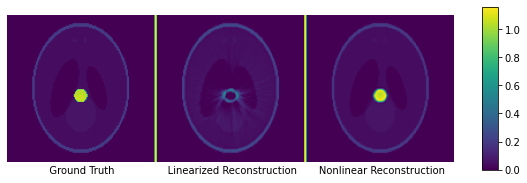

In [71]:
# Generate nice figures

def separate_horizontally(img, linewidth=1):
    maxval = np.max(img.flatten())
    H, W = img.shape
    assert H * 3 == W
    newimg = np.ones((H, W + linewidth*2)) * maxval
    newimg[:,:H] = img[:,:H]
    newimg[:,H+linewidth:2*H+linewidth] = img[:,H:2*H]
    newimg[:,2*H+2*linewidth:] = img[:,2*H:]
    return newimg

def make_figure(how_easy):
    # nonlinear_path = f'jax_logs/{how_easy}easy_synthetic_nonnegative/epoch_0/sigma_grid.npy'
    # linear_path = f'jax_logs/{how_easy}easy_synthetic_linearized_nonnegative/epoch_0/sigma_grid.npy'
    nonlinear_path = f'jax_logs/shepp_fifthdensity/nonlinear_{how_easy}_nonnegative/epoch_0/sigma_grid.npy'
    linear_path = f'jax_logs/shepp_fifthdensity/linear_{how_easy}_nonnegative/epoch_0/sigma_grid.npy'
    nonlinear_grid = np.load(nonlinear_path)
    linear_grid = np.load(linear_path)
    reso = nonlinear_grid.shape[0]
    # gt_path = f'/home/datasets/ct_synthetic/{how_easy}easy_synthetic_volume_reso{reso}.tif'
    gt_path = f'/home/datasets/ct_shepp/fifthdensity_{how_easy}_volume_reso128.tif'
    gt_grid = tifffile.imread(gt_path)

    # xslice = np.concatenate([gt_grid[reso//2,:,:], linear_grid[reso//2,:,:], nonlinear_grid[reso//2,:,:]], axis=1)
    # yslice = np.concatenate([gt_grid[:,reso//2,:], linear_grid[:,reso//2,:], nonlinear_grid[:,reso//2,:]], axis=1)
    slice = int(3/8. * reso)
    zslice = np.concatenate([gt_grid[:,:,slice], linear_grid[:,:,slice], nonlinear_grid[:,:,slice]], axis=1)

    # allslices = np.concatenate([xslice, yslice, zslice], axis=0)
    allslices = separate_horizontally(zslice, linewidth=2)
    plt.figure(figsize=(10,3))
    plt.imshow(allslices, cmap='viridis')
    plt.xticks([])
    plt.yticks([])
    plt.colorbar(aspect=10)
    plt.xlabel(f'           Ground Truth                 Linearized Reconstruction       Nonlinear Reconstruction')
    plt.box(False)
    plt.show()


# make_figure('super_')
# make_figure('very_')
# make_figure('semi_')
# make_figure('')

make_figure('0.05')
make_figure('0.1')
make_figure('0.2')
make_figure('0.5')
make_figure('1')